In [1]:
from IPython.display import display
from IPython.display import clear_output
import PIL
import numpy as np
import time
import os
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import sys
from matplotlib import cm
import seaborn as sns
import tensorflow as tf
import tensorlayer as tl

In [2]:
tf.reset_default_graph()

In [3]:
tf.logging.set_verbosity(tf.logging.DEBUG)

In [4]:
SCALAR = 80

In [5]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))

5000


In [6]:
def check_RAD_id(RAD_id):
    sum_list = []
    for k in range(61):
        sum_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().sum())
    sum_list = np.array(sum_list)
    if i % 100 == 0:
        print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
        print(i, sum_list[:7])
    if sum_list.mean() < 251001 * 0:
        return False
    for k in range(59):
        if abs(sum_list[k] + sum_list[k + 2] - 2 * sum_list[k + 1]) > 251001 * 2:
            return False
    return True

In [7]:
RAD_id_list = raw_RAD_id_list

In [8]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = []
for (i, RAD_id) in enumerate(raw_RAD_id_list[:100]):
    if check_RAD_id(RAD_id):
        RAD_id_list.append(RAD_id)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-08-20 19:39:40
00:00:00
0 [-218731 -223051 -219804 -220007 -214895 -215379 -215980]
end time: 2018-08-20 19:39:45
00:00:04
36


In [15]:
def read_by_RAD_id(RAD_id):
    x_matrix = np.empty((30, 501, 501, 1))
    for i in range(30):
        x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    y_matrix = np.empty((30, 501, 501, 1))
    for i in range(30):
        y_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 31))).astype(np.int8).reshape((501, 501, 1)) / SCALAR
    return ([x_matrix], [y_matrix])

In [21]:
all_start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# sess.close()
# with tf.device("/gpu:0"):
tf.reset_default_graph()
sess = tf.InteractiveSession()

# define placeholder
x = tf.placeholder(tf.float32, shape=[None, 30, 501, 501, 1], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 30, 501, 501, 1], name='y_')

# define the network
# network = tl.layers.InputLayer(x, name='input')
network = x
# network = tf.keras.layers.AveragePooling3D(pool_size=(3, 3, 1), data_format='channels_first')(network)
network = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(5, 5), input_shape=network.shape, padding='same', return_sequences=True)(network)
print(network)
network = tf.keras.layers.Conv3D(filters=1, kernel_size=(1, 1, 1), data_format='channels_last')(network)
print(network)
# network.set_shape((None, 6, 167, 167, 1))
# network = tf.keras.layers.Conv3DTranspose(filters=1, kernel_size=(1, 3, 3), strides=(1, 3, 3))(network)
# print(network)

y = network
# cost = tf.losses.mean_squared_error(y, y_, weights=y_)
cost = tf.losses.mean_squared_error(y, y_)

# train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.003).minimize(cost)

sess.run(tf.global_variables_initializer())

n_epoch = 200
print_freq = 5

sum_cost = 0
for epoch in range(n_epoch):
    for i in range(1):
        X_train, Y_train = read_by_RAD_id(RAD_id_list[i])
        feed_dict = {x: X_train, y_: Y_train}
    #     feed_dict.update(network.all_drop)  # enable noise layers
        train_cost, _ = sess.run([cost, train_op], feed_dict=feed_dict)
        sum_cost += train_cost / (Y_train[0].sum() + 251001)
        if i % print_freq == 0:
            print('%3d'%epoch, '%3d'%i, RAD_id_list[i], time.strftime('%H:%M:%S', time.localtime()), time.strftime('%H:%M:%S', time.gmtime(time.time() - all_start_time)), '%5.5f'%(sum_cost * 10 ** 10))
        sum_cost = 0
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - all_start_time)))

start time: 2018-08-20 20:01:12
Tensor("conv_lst_m2d/transpose_1:0", shape=(?, ?, 501, 501, 16), dtype=float32)
Tensor("conv3d/BiasAdd:0", shape=(?, ?, 501, 501, 1), dtype=float32)
  0   0 RAD_346482464229534 20:01:16 00:00:04 241.45029
  1   0 RAD_346482464229534 20:01:18 00:00:06 241.24989
  2   0 RAD_346482464229534 20:01:20 00:00:08 241.05362
  3   0 RAD_346482464229534 20:01:22 00:00:10 240.86082
  4   0 RAD_346482464229534 20:01:24 00:00:12 240.67176
  5   0 RAD_346482464229534 20:01:26 00:00:14 240.48620
  6   0 RAD_346482464229534 20:01:28 00:00:16 240.30432
  7   0 RAD_346482464229534 20:01:30 00:00:17 240.12580
  8   0 RAD_346482464229534 20:01:32 00:00:19 239.95061
  9   0 RAD_346482464229534 20:01:34 00:00:21 239.77886
 10   0 RAD_346482464229534 20:01:36 00:00:23 239.61019
 11   0 RAD_346482464229534 20:01:38 00:00:25 239.44497
 12   0 RAD_346482464229534 20:01:40 00:00:27 239.28265
 13   0 RAD_346482464229534 20:01:42 00:00:29 239.12358
 14   0 RAD_346482464229534 20:01:4

144   0 RAD_346482464229534 20:06:06 00:04:54 231.56283
145   0 RAD_346482464229534 20:06:08 00:04:56 231.55011
146   0 RAD_346482464229534 20:06:10 00:04:58 231.53761
147   0 RAD_346482464229534 20:06:12 00:05:00 231.52538
148   0 RAD_346482464229534 20:06:14 00:05:02 231.51340
149   0 RAD_346482464229534 20:06:16 00:05:04 231.50157
150   0 RAD_346482464229534 20:06:18 00:05:06 231.49003
151   0 RAD_346482464229534 20:06:20 00:05:08 231.47869
152   0 RAD_346482464229534 20:06:22 00:05:10 231.46755
153   0 RAD_346482464229534 20:06:24 00:05:12 231.45665
154   0 RAD_346482464229534 20:06:26 00:05:14 231.44596
155   0 RAD_346482464229534 20:06:28 00:05:16 231.43540
156   0 RAD_346482464229534 20:06:30 00:05:18 231.42509
157   0 RAD_346482464229534 20:06:32 00:05:20 231.41502
158   0 RAD_346482464229534 20:06:34 00:05:22 231.40508
159   0 RAD_346482464229534 20:06:36 00:05:24 231.39534
160   0 RAD_346482464229534 20:06:38 00:05:26 231.38576
161   0 RAD_346482464229534 20:06:40 00:05:28 23

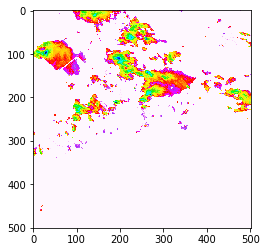

↓↓↓第0序列，第0次，下面的是模型的输出，上面的是真实值↑↑↑


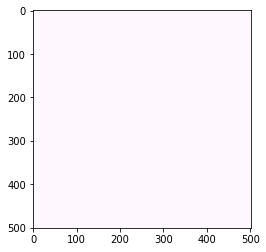


------------------------------------



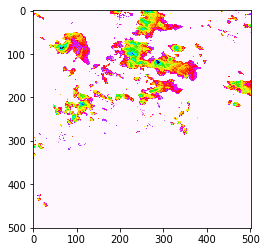

↓↓↓第0序列，第7次，下面的是模型的输出，上面的是真实值↑↑↑


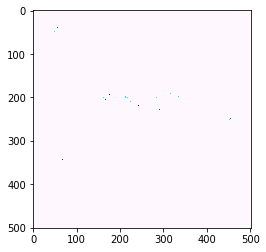


------------------------------------



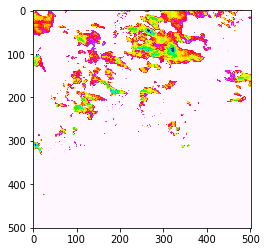

↓↓↓第0序列，第14次，下面的是模型的输出，上面的是真实值↑↑↑


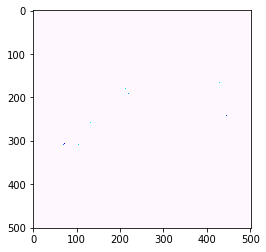


------------------------------------



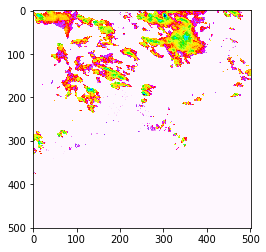

↓↓↓第0序列，第21次，下面的是模型的输出，上面的是真实值↑↑↑


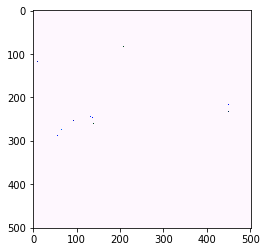


------------------------------------



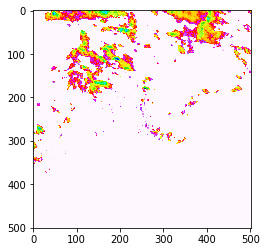

↓↓↓第0序列，第28次，下面的是模型的输出，上面的是真实值↑↑↑


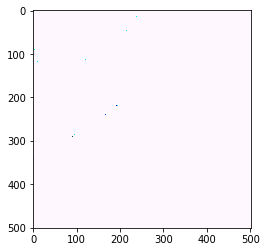


------------------------------------



In [20]:
for i in range(1):
    X_train, Y_train = read_by_RAD_id(RAD_id_list[i])
    feed_dict = {x: X_train}
    prediction = sess.run(y, feed_dict=feed_dict)
    prediction = prediction[0] * SCALAR
    Y_validation = Y_train[0] * SCALAR
    for j in range(0, 30, 7):
        plt.imshow(Y_validation[j].reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('↓↓↓第%d序列，第%d次，下面的是模型的输出，上面的是真实值↑↑↑' % (i, j))
        prediction[j] = np.where(prediction[j]<3, -1, prediction[j])
        plt.imshow(prediction[j].reshape((501,501)), cmap=cm.gist_ncar_r)
        plt.show()
        print('\n------------------------------------\n')

In [ ]:
Y_train[0][1].shape

In [ ]:
feed_dict = {x: X_train}
prediction = sess.run(y, feed_dict=feed_dict)
prediction = prediction[0] * SCALAR
Y_validation = Y_train[0] * SCALAR
plt.imshow(Y_validation.reshape((501,501)), cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
prediction = np.where(prediction<3, -1, prediction)
plt.imshow(prediction.reshape((501,501)), cmap=cm.gist_ncar_r)
plt.show()
print('\n------------------------------------\n')